## Bước 1: Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

from tqdm import tqdm

## Bước 2: Load bộ dữ liệu NER cho tiếng Anh

In [2]:
data = pd.read_csv('/kaggle/input/ner-en/ner_dataset.csv', encoding='latin1')
data = data.fillna(method="ffill")
data.head(24)

/tmp/ipykernel_47/547639094.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


## Bước 3: Lấy các câu và các thẻ tương ứng

In [3]:
# group data by sentence and extract words and tags
sentences = []
tags = []

for sentence_id, group in data.groupby('Sentence #'):
    words = group['Word'].tolist()
    tag_list = group['Tag'].tolist()
    sentences.append(words)
    tags.append(tag_list)

print(f"Tổng số câu: {len(sentences)}")
print(f"Câu đầu tiên: {sentences[0]}")
print(f"Tags đầu tiên: {tags[0]}")
print(f"Độ dài câu đầu tiên: {len(sentences[0])}")

Tổng số câu: 47959
Câu đầu tiên: ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
Tags đầu tiên: ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
Độ dài câu đầu tiên: 24


## Bước 4: Ánh xạ giữa các câu và chỉ mục

In [4]:
# create word_to_idx mapping
unique_words = set()
for sentence in sentences:
    unique_words.update(sentence)

word_to_idx = {'<PAD>': 0, '<UNK>': 1}
for idx, word in enumerate(sorted(unique_words), start=2):
    word_to_idx[word] = idx

# create tag_to_idx mapping
unique_tags = set()
for tag_list in tags:
    unique_tags.update(tag_list)

tag_to_idx = {}
for idx, tag in enumerate(sorted(unique_tags)):
    tag_to_idx[tag] = idx

# create reverse mapping
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

# convert sentences and tags into indices
sentences_idx = []
for sentence in sentences:
    sentence_idx = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in sentence]
    sentences_idx.append(sentence_idx)

tags_idx = []
for tag_list in tags:
    tag_idx = [tag_to_idx[tag] for tag in tag_list]
    tags_idx.append(tag_idx)

print(f"Số lượng từ duy nhất: {len(word_to_idx)}")
print(f"Số lượng tags duy nhất: {len(tag_to_idx)}")
print(f"Tag mappings:")
print(f"tag_to_idx: {tag_to_idx}")
print(f"idx_to_tag: {idx_to_tag}")

Số lượng từ duy nhất: 35179
Số lượng tags duy nhất: 17
Tag mappings:
tag_to_idx: {'B-art': 0, 'B-eve': 1, 'B-geo': 2, 'B-gpe': 3, 'B-nat': 4, 'B-org': 5, 'B-per': 6, 'B-tim': 7, 'I-art': 8, 'I-eve': 9, 'I-geo': 10, 'I-gpe': 11, 'I-nat': 12, 'I-org': 13, 'I-per': 14, 'I-tim': 15, 'O': 16}
idx_to_tag: {0: 'B-art', 1: 'B-eve', 2: 'B-geo', 3: 'B-gpe', 4: 'B-nat', 5: 'B-org', 6: 'B-per', 7: 'B-tim', 8: 'I-art', 9: 'I-eve', 10: 'I-geo', 11: 'I-gpe', 12: 'I-nat', 13: 'I-org', 14: 'I-per', 15: 'I-tim', 16: 'O'}


## Bước 5: Padding đầu vào và cắt dữ liệu thành tập Train/Test

Text(0.5, 1.0, 'Phân bố chiều dài câu trong tập dữ liệu')

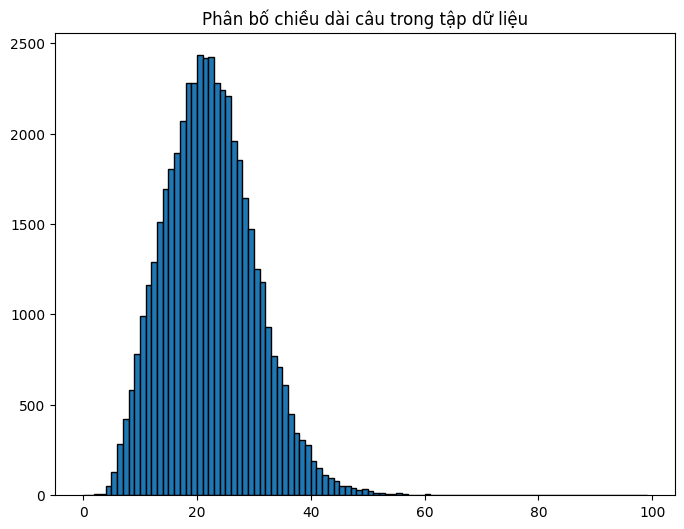

In [5]:
# vẽ biểu đồ thể hiện phân bố chiều dài của câu trong tập dữ liệu:
plt.figure(figsize=(8, 6), dpi=100)
plt.hist([len(sentence) for sentence in sentences], bins=range(0, 100, 1), edgecolor='black')
plt.title('Phân bố chiều dài câu trong tập dữ liệu')

Có thể thấy độ dài an toàn của câu là khoảng 40-50

In [6]:
max_len = 50
# X is a number representation of the words
X = [torch.tensor(s, dtype=torch.long) for s in sentences_idx]
y = [torch.tensor(t, dtype=torch.long) for t in tags_idx]
# padding X, y
X = pad_sequence(X, batch_first=True, padding_value=word_to_idx['<PAD>'])
y = pad_sequence(y, batch_first=True, padding_value=tag_to_idx['O'])

X = X[:, :max_len]
y = y[:, :max_len]

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=53)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=53)

## Bước 6: Xây dựng Mô hình LSTM hai chiều (bi-LSTM)

In [8]:
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_tags, num_layers=1, dropout=0.5):
        super(BiLSTM_NER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, num_tags)  # *2 vì bidirectional
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        embedded = self.dropout(embedded)
        
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_len, hidden_dim * 2)
        lstm_out = self.dropout(lstm_out)
        
        tag_space = self.fc(lstm_out)  # (batch_size, seq_len, num_tags)
        return tag_space

# model configs
vocab_size = len(word_to_idx)
embedding_dim = 100
hidden_dim = 256
num_tags = len(tag_to_idx)
num_layers = 3
dropout = 0.3

model = BiLSTM_NER(vocab_size, embedding_dim, hidden_dim, num_tags, num_layers, dropout)
print(f"Model architecture:")
print(model)
print(f"Vocab size: {vocab_size}")
print(f"Number of tags: {num_tags}")

# Đếm số parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model architecture:
BiLSTM_NER(
  (embedding): Embedding(35179, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=17, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Vocab size: 35179
Number of tags: 17
Total parameters: 7,413,725
Trainable parameters: 7,413,725


## Bước 7: Huấn luyện Model

In [9]:
# Dataset class
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoader
batch_size = 64
train_dataset = NERDataset(X_train, y_train)
val_dataset = NERDataset(X_val, y_val)
test_dataset = NERDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# training settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training parameters
num_epochs = 10
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_accuracies = []

Using device: cuda


In [11]:
for epoch in tqdm(range(num_epochs), desc="Training"):
    # Training phase
    model.train()
    train_loss = 0
    train_batches = 0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)  # (batch_size, seq_len, num_tags)
        
        # Reshape for loss calculation
        outputs = outputs.view(-1, num_tags)  # (batch_size * seq_len, num_tags)
        batch_y = batch_y.view(-1)  # (batch_size * seq_len)
        
        # Tạo mask để ignore padding tokens 
        mask = (batch_X.view(-1) != 0).float()  # (batch_size * seq_len)
        
        # Tính loss cho từng token
        loss_per_token = criterion(outputs, batch_y)  # (batch_size * seq_len)
        # Chỉ tính loss cho non-padding tokens
        loss = (loss_per_token * mask).sum() / mask.sum()
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_batches = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_X)
            outputs = outputs.view(-1, num_tags)
            batch_y = batch_y.view(-1)
            
            # Tạo mask để ignore padding tokens
            mask = (batch_X.view(-1) != 0).bool()
            loss_per_token = criterion(outputs, batch_y)
            loss = (loss_per_token * mask.float()).sum() / mask.sum()
            val_loss += loss.item()
            val_batches += 1
            
            # Tính accuracy
            preds = torch.argmax(outputs, dim=1)
            # Chỉ lấy predictions và labels cho non-padding tokens
            all_preds.extend(preds[mask].cpu().numpy())
            all_labels.extend(batch_y[mask].cpu().numpy())
    
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    # Tính accuracy
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_accuracy)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_bilstm_ner_model.pth')
        print(f"Epoch {epoch+1}/{num_epochs} - Best model saved!")
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f" Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
    print("-" * 60)

Training:  10%|█         | 1/10 [00:20<03:03, 20.36s/it]

Epoch 1/10 - Best model saved!
Epoch 1/10
 Train Loss: 0.4444 | Val Loss: 0.2059 | Val Accuracy: 0.9413
------------------------------------------------------------


Training:  20%|██        | 2/10 [00:39<02:37, 19.75s/it]

Epoch 2/10 - Best model saved!
Epoch 2/10
 Train Loss: 0.2061 | Val Loss: 0.1498 | Val Accuracy: 0.9568
------------------------------------------------------------


Training:  30%|███       | 3/10 [00:58<02:16, 19.52s/it]

Epoch 3/10 - Best model saved!
Epoch 3/10
 Train Loss: 0.1614 | Val Loss: 0.1341 | Val Accuracy: 0.9611
------------------------------------------------------------


Training:  40%|████      | 4/10 [01:18<01:57, 19.53s/it]

Epoch 4/10 - Best model saved!
Epoch 4/10
 Train Loss: 0.1385 | Val Loss: 0.1254 | Val Accuracy: 0.9629
------------------------------------------------------------


Training:  50%|█████     | 5/10 [01:38<01:37, 19.53s/it]

Epoch 5/10 - Best model saved!
Epoch 5/10
 Train Loss: 0.1225 | Val Loss: 0.1231 | Val Accuracy: 0.9647
------------------------------------------------------------


Training:  60%|██████    | 6/10 [01:57<01:18, 19.61s/it]

Epoch 6/10 - Best model saved!
Epoch 6/10
 Train Loss: 0.1103 | Val Loss: 0.1164 | Val Accuracy: 0.9650
------------------------------------------------------------


Training:  70%|███████   | 7/10 [02:17<00:58, 19.63s/it]

Epoch 7/10 - Best model saved!
Epoch 7/10
 Train Loss: 0.1010 | Val Loss: 0.1133 | Val Accuracy: 0.9667
------------------------------------------------------------


Training:  80%|████████  | 8/10 [02:37<00:39, 19.65s/it]

Epoch 8/10
 Train Loss: 0.0923 | Val Loss: 0.1156 | Val Accuracy: 0.9665
------------------------------------------------------------


Training:  90%|█████████ | 9/10 [02:56<00:19, 19.55s/it]

Epoch 9/10 - Best model saved!
Epoch 9/10
 Train Loss: 0.0860 | Val Loss: 0.1118 | Val Accuracy: 0.9672
------------------------------------------------------------


Training: 100%|██████████| 10/10 [03:15<00:00, 19.58s/it]

Epoch 10/10
 Train Loss: 0.0801 | Val Loss: 0.1151 | Val Accuracy: 0.9680
------------------------------------------------------------


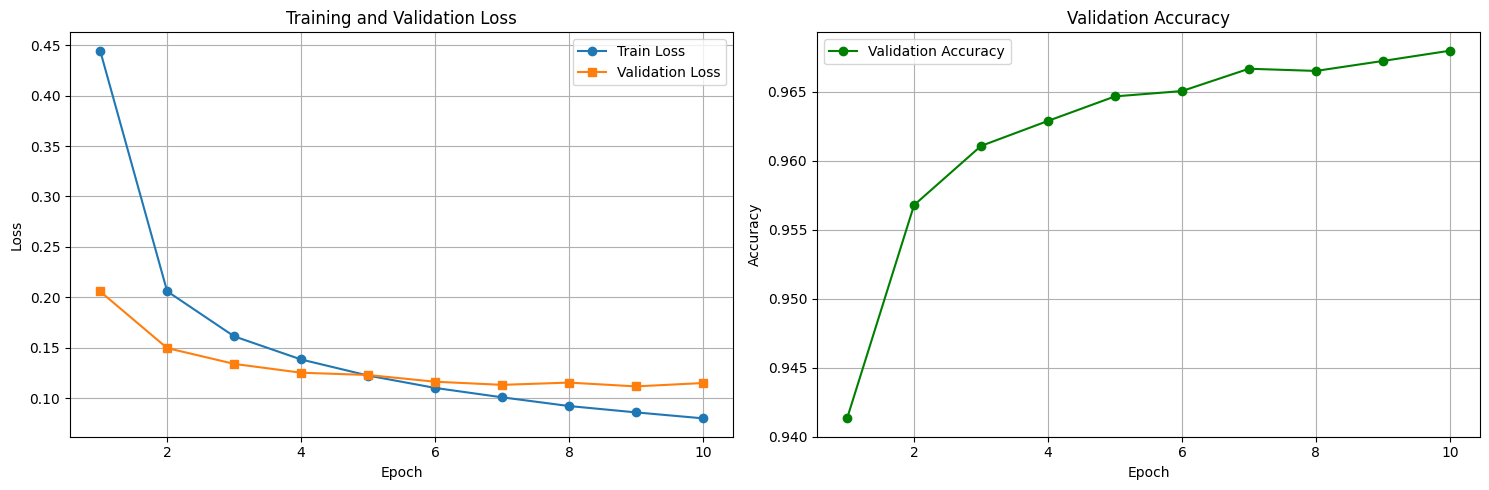

In [12]:
# biểu đồ loss và accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# biểu đồ loss
ax1.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
ax1.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# biểu đồ accuracy
ax2.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Bước 8: Đánh giá mô hình

In [13]:
# Load best model để đánh giá
model.load_state_dict(torch.load('best_bilstm_ner_model.pth'))
model.eval()

# Đánh giá trên test set
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        outputs = model(batch_X)
        outputs = outputs.view(-1, num_tags)
        batch_y = batch_y.view(-1)
        
        # Tạo mask để ignore padding tokens
        mask = (batch_X.view(-1) != 0).bool()
        
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds[mask].cpu().numpy())
        all_labels.extend(batch_y[mask].cpu().numpy())

print(f"Đã dự đoán {len(all_preds)} tokens")
print(f"Số lượng labels: {len(all_labels)}")

Đã dự đoán 156741 tokens
Số lượng labels: 156741


In [14]:
# Accuracy (micro - overall)
accuracy_micro = accuracy_score(all_labels, all_preds)

# F1-score (micro và macro)
f1_micro = f1_score(all_labels, all_preds, average='micro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

print("=" * 70)
print("KẾT QUẢ ĐÁNH GIÁ TỔNG HỢP TRÊN TEST SET (Micro và Macro)")
print("=" * 70)
print(f"\nAccuracy (Micro): {accuracy_micro:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")

KẾT QUẢ ĐÁNH GIÁ TỔNG HỢP TRÊN TEST SET (Micro và Macro)

Accuracy (Micro): 0.9671
F1-Score (Micro): 0.9671
F1-Score (Macro): 0.6192


In [15]:
# Tính accuracy và F1-score cho từng tag
tag_names = [idx_to_tag[i] for i in range(len(tag_to_idx))]
tag_accuracies = []
tag_f1_scores = []

for tag_idx in range(len(tag_to_idx)):
    tag_mask = [label == tag_idx for label in all_labels]
    num_tag_samples = sum(tag_mask)
    
    if num_tag_samples > 0:
        # Tính accuracy: số tokens được predict đúng / tổng số tokens của tag này
        correct = sum([all_labels[i] == all_preds[i] for i in range(len(all_labels)) if tag_mask[i]])
        tag_acc = correct / num_tag_samples
        
        # Tính F1-score cho tag này
        binary_labels = [1 if label == tag_idx else 0 for label in all_labels]
        binary_preds = [1 if pred == tag_idx else 0 for pred in all_preds]
        tag_f1 = f1_score(binary_labels, binary_preds, zero_division=0)
    else:
        tag_acc = 0.0
        tag_f1 = 0.0
    
    tag_accuracies.append(tag_acc)
    tag_f1_scores.append(tag_f1)

# Tính Accuracy (Macro)
accuracy_macro = np.mean(tag_accuracies)

# Tạo bảng kết quả
results_df = pd.DataFrame({
    'Tag': tag_names,
    'Accuracy': [f'{acc:.4f}' for acc in tag_accuracies],
    'F1-Score': [f'{f1:.4f}' for f1 in tag_f1_scores]
})

results_df_numeric = pd.DataFrame({
    'Tag': tag_names,
    'Accuracy': tag_accuracies,
    'F1-Score': tag_f1_scores
})

# kết quả tổng hợp
print("=" * 70)
print("KẾT QUẢ ĐÁNH GIÁ TỔNG HỢP")
print("=" * 70)
print(f"Accuracy (Micro): {accuracy_micro:.4f}")
print(f"Accuracy (Macro): {accuracy_macro:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")

# kết quả cho từng nhãn thực thể
print("\n" + "=" * 70)
print("KẾT QUẢ CHI TIẾT THEO TỪNG NHÃN THỰC THỂ")
print("=" * 70)
print(results_df.to_string(index=False))

# Classification Report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(all_labels, all_preds, target_names=tag_names, digits=4))

KẾT QUẢ ĐÁNH GIÁ TỔNG HỢP
Accuracy (Micro): 0.9671
Accuracy (Macro): 0.6110
F1-Score (Micro): 0.9671
F1-Score (Macro): 0.6192

KẾT QUẢ CHI TIẾT THEO TỪNG NHÃN THỰC THỂ
  Tag Accuracy F1-Score
B-art   0.0000   0.0000
B-eve   0.4444   0.4819
B-geo   0.9003   0.8813
B-gpe   0.9313   0.9470
B-nat   0.2381   0.3226
B-org   0.7094   0.7404
B-per   0.8057   0.8151
B-tim   0.8847   0.8943
I-art   0.0000   0.0000
I-eve   0.4103   0.3441
I-geo   0.8511   0.8316
I-gpe   0.5484   0.6939
I-nat   0.2500   0.1667
I-org   0.7949   0.7793
I-per   0.8515   0.8576
I-tim   0.7765   0.7806
    O   0.9907   0.9899

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       B-art     0.0000    0.0000    0.0000        56
       B-eve     0.5263    0.4444    0.4819        45
       B-geo     0.8630    0.9003    0.8813      5729
       B-gpe     0.9632    0.9313    0.9470      2330
       B-nat     0.5000    0.2381    0.3226        21
       B-org     0.7743    0.7094    0.7404      304

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


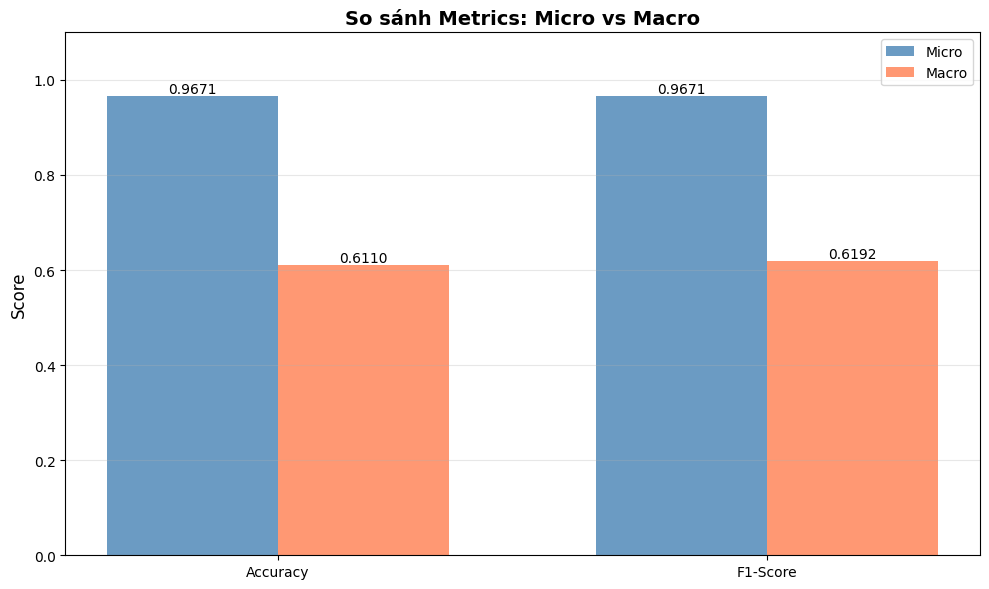

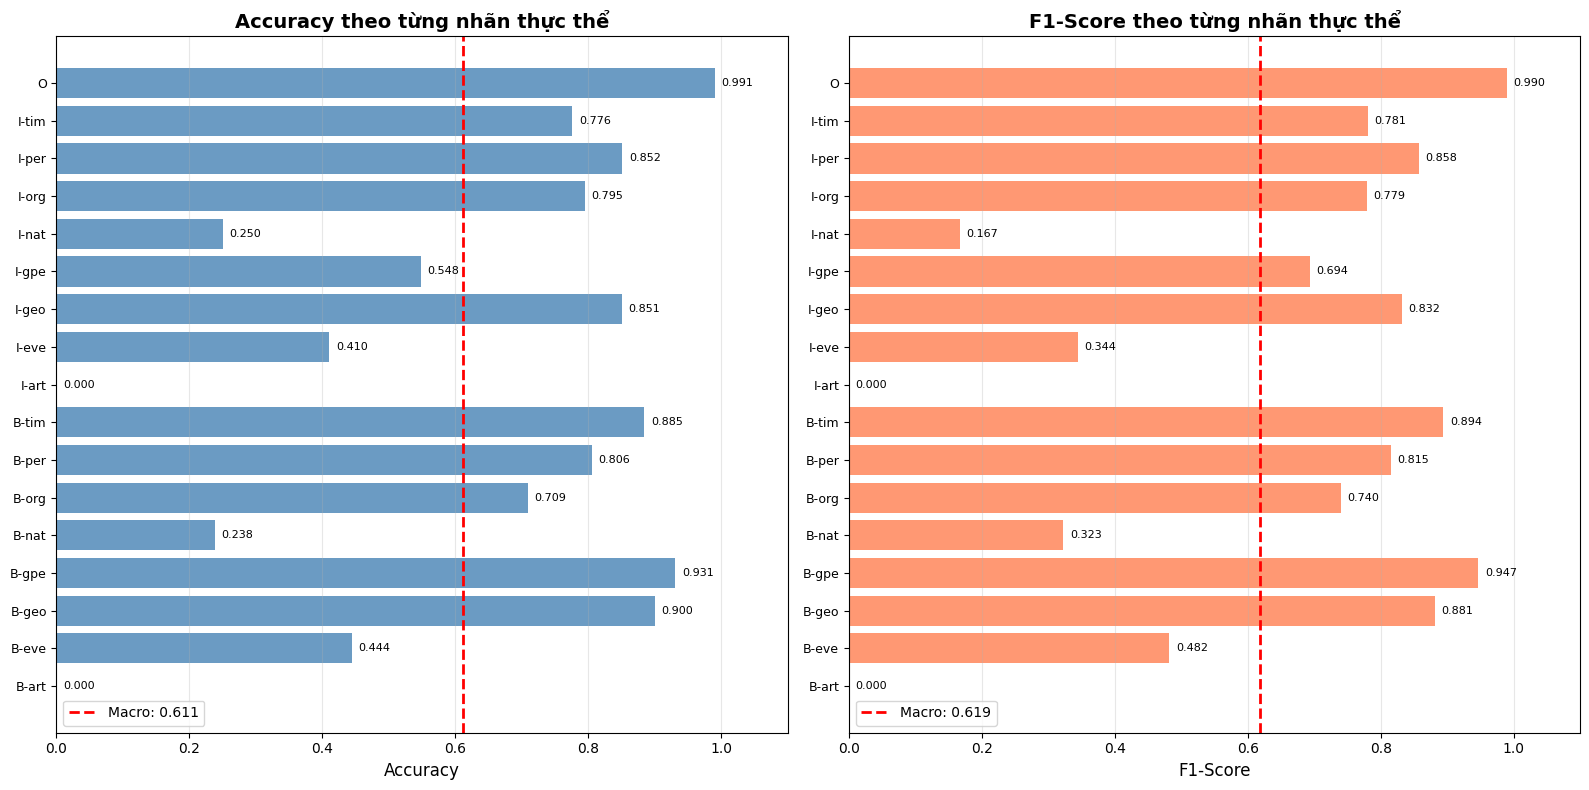

In [16]:
# Visualization: So sánh Micro vs Macro
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['Accuracy', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, [accuracy_micro, f1_micro], width, label='Micro', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, [accuracy_macro, f1_macro], width, label='Macro', alpha=0.8, color='coral')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('So sánh Metrics: Micro vs Macro', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization: Kết quả theo từng tag
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
x_pos = np.arange(len(tag_names))

# Bar chart Accuracy
bars1 = ax1.barh(x_pos, tag_accuracies, alpha=0.8, color='steelblue')
ax1.set_yticks(x_pos)
ax1.set_yticklabels(tag_names, fontsize=9)
ax1.set_xlabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy theo từng nhãn thực thể', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1.1])
ax1.axvline(x=accuracy_macro, color='red', linestyle='--', linewidth=2, label=f'Macro: {accuracy_macro:.3f}')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Thêm giá trị trên các cột
for i, (bar, acc) in enumerate(zip(bars1, tag_accuracies)):
    width = bar.get_width()
    ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{acc:.3f}', ha='left', va='center', fontsize=8)

# Bar chart F1-Score
bars2 = ax2.barh(x_pos, tag_f1_scores, alpha=0.8, color='coral')
ax2.set_yticks(x_pos)
ax2.set_yticklabels(tag_names, fontsize=9)
ax2.set_xlabel('F1-Score', fontsize=12)
ax2.set_title('F1-Score theo từng nhãn thực thể', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1.1])
ax2.axvline(x=f1_macro, color='red', linestyle='--', linewidth=2, label=f'Macro: {f1_macro:.3f}')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# Thêm giá trị trên các cột
for i, (bar, f1) in enumerate(zip(bars2, tag_f1_scores)):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{f1:.3f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

## Bước 9: Lưu model

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/checkpoints_cau1')
print("Model saved!")

Model saved!
